# Try Light Gradient Boosting method

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import optuna
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Suppress Optuna and LightGBM logs
optuna.logging.set_verbosity(optuna.logging.WARNING)

/mnt/mini/envs/sklearn-env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def make_lags(df, cols, lags):
    return pd.concat([df[col].shift(lag).rename(f"{col}_L{lag}") for col in cols for lag in lags], axis=1)

In [3]:
df = pd.read_csv("../../../data/cleaned/multi_var_wind_hourly_cleaned.csv")


In [4]:
df.columns

Index(['datetime', 'pressure', 'temperature', 'humidity', 'wind_direction',
       'wind_speed', 'u', 'v', 'wind_speed_reconstructed', 'pressure_24h'],
      dtype='object')

In [5]:
df = df[['datetime', 'pressure', 'temperature', 'humidity',
       'wind_speed', 'u', 'v', ]]

In [ ]:
df = df[['timestamp', 'temp_c', 'rel_humidity', 'wind_speed_kmh', 'pressure_kpa',
         'u', 'v', ]]

In [ ]:
clmns = {'timestamp':'datetime',
         'temp_c':'temperature',
         'rel_humidity':'humidity',
         'wind_speed_kmh':'wind_speed',
         'pressure_kpa':'pressure',
          }
df.rename(columns=clmns, inplace=True)

In [ ]:
df.columns

In [6]:
df = df.sort_values('datetime').reset_index(drop=True)
df['wind_speed'] = df['wind_speed'].astype(float)

In [7]:
df.head()

,datetime,pressure,temperature,humidity,wind_speed,u,v
0,2024-01-01 00:00:00,758.466667,-1.016667,62.166667,0.100000,-0.022693,-0.047340
1,2024-01-01 01:00:00,758.383333,-1.533333,64.000000,0.283333,-0.113825,0.011167
2,2024-01-01 02:00:00,758.383333,-1.150000,61.333333,0.200000,-0.169286,-0.061781
3,2024-01-01 03:00:00,758.783333,-1.166667,58.666667,0.500000,0.142045,-0.397690
4,2024-01-01 04:00:00,759.000000,-1.483333,62.166667,0.966667,-0.512590,-0.609574


In [8]:
df.isnull().sum()

datetime       0
pressure       0
temperature    0
humidity       0
wind_speed     0
u              0
v              0
dtype: int64

In [9]:
# ensure the column is datetime *type*
df['datetime'] = pd.to_datetime(df['datetime'])   # or df['datetime'] if that's the name

# now extract hour
df['hour'] = df['datetime'].dt.hour
df['sin_h'] = np.sin(2 * np.pi * df['hour'] / 24)
df['cos_h'] = np.cos(2 * np.pi * df['hour'] / 24)

In [10]:
# 1. REVISED LAGS (Option 2)
# Keep recent history (1,2,3) and the exact time yesterday (24). 
# Drop the noisy lags (23, 25, 48).
DAYS_BACK_INDEX = 24 
LAGS = [1, 2, 3, DAYS_BACK_INDEX] 
cols_to_lag = ['pressure', 'temperature', 'wind_speed', 'u', 'v']


# 2. Apply Lags
df_lags = make_lags(df, cols_to_lag, LAGS)
df_final = pd.concat([df, df_lags], axis=1)

# 3. Add Rolling Features (Trend & Volatility)
# Calculated on the CURRENT available data (at time t)
# This captures the "average weather of the last day" and "gustiness"
df_final['wind_rolling_24_mean'] = df_final['wind_speed'].rolling(window=DAYS_BACK_INDEX).mean()
df_final['wind_rolling_24_std'] = df_final['wind_speed'].rolling(window=DAYS_BACK_INDEX).std()

# 4. Target Creation & Cleanup
df_final['target_wind_speed'] = df_final['wind_speed'].shift(-1)
df_final.dropna(inplace=True)
X = df_final.drop(['datetime', 'target_wind_speed'], axis=1)
y = df_final['target_wind_speed']

In [11]:
df_final.head()

,datetime,pressure,temperature,humidity,wind_speed,u,v,hour,sin_h,cos_h,...,u_L2,u_L3,u_L24,v_L1,v_L2,v_L3,v_L24,wind_rolling_24_mean,wind_rolling_24_std,target_wind_speed
24,2024-01-02 00:00:00,760.400000,-1.933333,89.166667,1.050000,-0.871871,-0.322368,0,0.000000,1.000000,...,-0.875094,-0.263938,-0.022693,-0.419428,-0.058704,-0.166929,-0.047340,1.252083,1.135976,0.933333
25,2024-01-02 01:00:00,760.216667,-2.183333,89.666667,0.933333,-0.889509,-0.096850,1,0.258819,0.965926,...,-0.459502,-0.875094,-0.113825,-0.322368,-0.419428,-0.058704,0.011167,1.279167,1.119505,0.700000
26,2024-01-02 02:00:00,760.200000,-2.416667,84.666667,0.700000,-0.572663,-0.323016,2,0.500000,0.866025,...,-0.871871,-0.459502,-0.169286,-0.096850,-0.322368,-0.419428,-0.061781,1.300000,1.103081,1.450000
27,2024-01-02 03:00:00,760.433333,-2.900000,81.500000,1.450000,0.187362,-1.400511,3,0.707107,0.707107,...,-0.889509,-0.871871,0.142045,-0.323016,-0.096850,-0.322368,-0.397690,1.339583,1.090094,1.750000
28,2024-01-02 04:00:00,760.716667,-2.666667,81.000000,1.750000,0.443680,-1.688442,4,0.866025,0.500000,...,-0.572663,-0.889509,-0.512590,-1.400511,-0.323016,-0.096850,-0.609574,1.372222,1.090170,0.083333


In [12]:
df_final.isnull().sum()

datetime                0
pressure                0
temperature             0
humidity                0
wind_speed              0
u                       0
v                       0
hour                    0
sin_h                   0
cos_h                   0
pressure_L1             0
pressure_L2             0
pressure_L3             0
pressure_L24            0
temperature_L1          0
temperature_L2          0
temperature_L3          0
temperature_L24         0
wind_speed_L1           0
wind_speed_L2           0
wind_speed_L3           0
wind_speed_L24          0
u_L1                    0
u_L2                    0
u_L3                    0
u_L24                   0
v_L1                    0
v_L2                    0
v_L3                    0
v_L24                   0
wind_rolling_24_mean    0
wind_rolling_24_std     0
target_wind_speed       0
dtype: int64

In [13]:
# 3. train/test split (last 720 rows locked)
# Split
train_end = len(df_final) - 720  # Test on last month




In [14]:
# Now includes: Lags, Time, Rolling Stats, AND Current State
FEATS = [c for c in df_final.columns if '_L' in c] + \
        ['sin_h', 'cos_h', 'wind_rolling_24_mean', 'wind_rolling_24_std'] + \
        ['pressure', 'temperature', 'u', 'v', 'wind_speed']

In [15]:
# Config
WINDOW_STRATEGY = "SLIDING"
SLIDING_WINDOW_SIZE = 4300 # ~6 months of hourly data
RETRAIN_INTERVAL = 168     # Weekly
TUNING_WINDOW_HOURS = 2160 # 3 Months for tuning history
N_TRIALS = 20              # Bayesian trials

In [16]:
df.columns

Index(['datetime', 'pressure', 'temperature', 'humidity', 'wind_speed', 'u',
       'v', 'hour', 'sin_h', 'cos_h'],
      dtype='object')

In [17]:
def objective_lgbm(trial, X, y):
    params = {
        # --- CRITICAL FIX: STABILITY ---
        'objective': 'regression',  # Use MSE (L2) for stable gradients
        'metric': 'mae',            # We still optimize for MAE score
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'n_jobs': -1,
        'random_state': 42,
        
        # --- NOISE PROTECTION ---
        # Prevents the model from splitting on tiny noise (critical for small data)
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 0.5),
        
        # --- SMALL DATA CONSTRAINTS ---
        'num_leaves': trial.suggest_int('num_leaves', 5, 31), 
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 20),
        
        # --- HYPERPARAMS ---
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 600),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
    }

    tscv = TimeSeriesSplit(n_splits=3)
    scores = []

    for train_index, val_index in tscv.split(X):
        X_train_cv, X_val_cv = X[train_index], X[val_index]
        y_train_cv, y_val_cv = y[train_index], y[val_index]

        model = lgb.LGBMRegressor(**params)
        model.fit(X_train_cv, y_train_cv)
        
        preds = model.predict(X_val_cv)
        mae = mean_absolute_error(y_val_cv, preds)
        scores.append(mae)

    return np.mean(scores)

In [18]:
# ==========================================
# 3. ROLLING LOOP
# ==========================================
print("Starting LightGBM Forecast with Bayesian Optimization...")

preds = []
model = None
current_best_params = {}

for t in range(train_end, len(df_final)):

    # --- PERIODIC RETRAINING ---
    if (t - train_end) % RETRAIN_INTERVAL == 0:
        print(f"\n--- [Step {t}] LightGBM Retraining & Tuning ---")
        
        # [A] RE-TUNING (Bayesian)
        tune_start_idx = max(0, t - TUNING_WINDOW_HOURS)
        tune_df = df_final.iloc[tune_start_idx:t]
        
        X_tune = tune_df[FEATS].values
        y_tune = tune_df['target_wind_speed'].values
        
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective_lgbm(trial, X_tune, y_tune), n_trials=N_TRIALS)
        
        current_best_params = study.best_params
        # Add fixed params back
        current_best_params.update({
            'objective': 'regression',
            'metric': 'mae',
            'verbosity': -1,
            'boosting_type': 'gbdt',
            'n_jobs': -1,
            'random_state': 42
        })
        
        print(f"Best MAE: {study.best_value:.4f}")

        # [B] RE-TRAINING (Sliding Window)
        train_start_idx = max(0, t - SLIDING_WINDOW_SIZE)
        train_window_df = df_final.iloc[train_start_idx:t]
        
        X_train = train_window_df[FEATS].values
        y_train = train_window_df['target_wind_speed'].values
        
        model = lgb.LGBMRegressor(**current_best_params)
        model.fit(X_train, y_train)

    # --- PREDICTION ---
    if model is None:
        preds.append(np.nan)
        continue

    x_next = df_final.iloc[[t]][FEATS].values
    preds.append(model.predict(x_next)[0])


Starting LightGBM Forecast with Bayesian Optimization...

--- [Step 9584] LightGBM Retraining & Tuning ---


/mnt/mini/envs/sklearn-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/mnt/mini/envs/sklearn-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/mnt/mini/envs/sklearn-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/mnt/mini/envs/sklearn-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/mnt/mini/envs/sklearn-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with featur

Best MAE: 0.8341


/mnt/mini/envs/sklearn-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/mnt/mini/envs/sklearn-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/mnt/mini/envs/sklearn-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/mnt/mini/envs/sklearn-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/mnt/mini/envs/sklearn-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with featur


--- [Step 9752] LightGBM Retraining & Tuning ---


/mnt/mini/envs/sklearn-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/mnt/mini/envs/sklearn-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/mnt/mini/envs/sklearn-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/mnt/mini/envs/sklearn-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/mnt/mini/envs/sklearn-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with featur

Best MAE: 0.8686


/mnt/mini/envs/sklearn-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/mnt/mini/envs/sklearn-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/mnt/mini/envs/sklearn-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/mnt/mini/envs/sklearn-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/mnt/mini/envs/sklearn-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with featur


--- [Step 9920] LightGBM Retraining & Tuning ---


/mnt/mini/envs/sklearn-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/mnt/mini/envs/sklearn-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/mnt/mini/envs/sklearn-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/mnt/mini/envs/sklearn-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/mnt/mini/envs/sklearn-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with featur

Best MAE: 0.7298


/mnt/mini/envs/sklearn-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/mnt/mini/envs/sklearn-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/mnt/mini/envs/sklearn-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/mnt/mini/envs/sklearn-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/mnt/mini/envs/sklearn-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with featur


--- [Step 10088] LightGBM Retraining & Tuning ---


/mnt/mini/envs/sklearn-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/mnt/mini/envs/sklearn-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/mnt/mini/envs/sklearn-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/mnt/mini/envs/sklearn-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/mnt/mini/envs/sklearn-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with featur

Best MAE: 0.7540


/mnt/mini/envs/sklearn-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/mnt/mini/envs/sklearn-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/mnt/mini/envs/sklearn-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/mnt/mini/envs/sklearn-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/mnt/mini/envs/sklearn-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with featur


--- [Step 10256] LightGBM Retraining & Tuning ---


/mnt/mini/envs/sklearn-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/mnt/mini/envs/sklearn-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/mnt/mini/envs/sklearn-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/mnt/mini/envs/sklearn-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/mnt/mini/envs/sklearn-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with featur

Best MAE: 0.7794


/mnt/mini/envs/sklearn-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/mnt/mini/envs/sklearn-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/mnt/mini/envs/sklearn-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/mnt/mini/envs/sklearn-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/mnt/mini/envs/sklearn-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with featur

In [19]:
# --- 4. EVALUATION ---
test_df = df_final.iloc[train_end:].copy()
test_df['pred_lgbm'] = preds

# Drop initial NaNs
test_df.dropna(subset=['pred_lgbm'], inplace=True)

# Calculate MAE
mae = mean_absolute_error(test_df['target_wind_speed'], test_df['pred_lgbm'])

print("\n" + "="*30)
print(f"FINAL LightGBM RESULTS (Stable L2)")
print(f"MAE: {mae:.5f} m/s")
print("="*30)



FINAL LightGBM RESULTS (Stable L2)
MAE: 0.67897 m/s


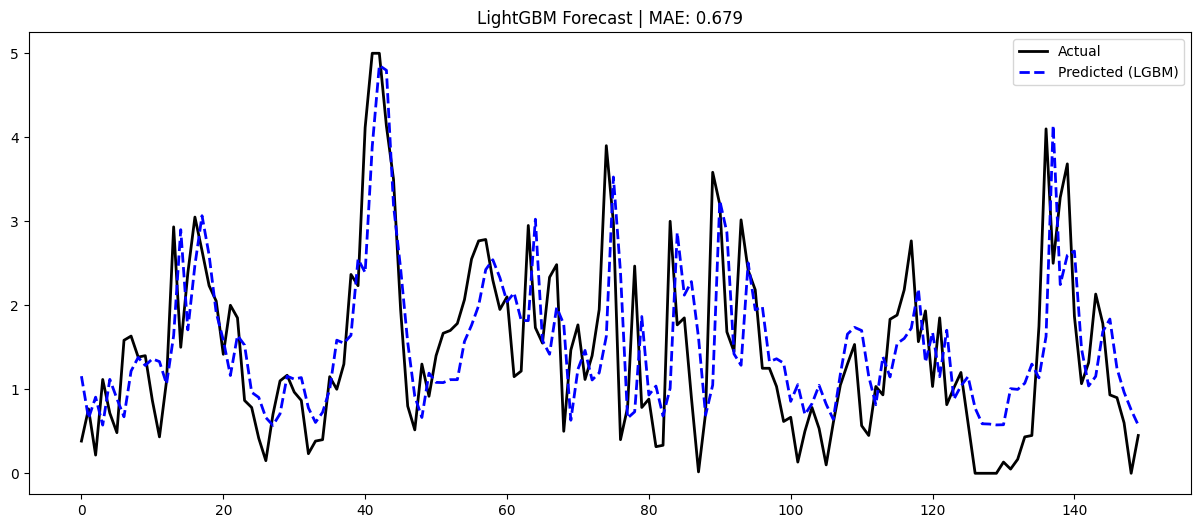

In [20]:

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 6))
limit = 150
plt.plot(test_df['target_wind_speed'].values[-limit:], label='Actual', color='black', linewidth=2)
plt.plot(test_df['pred_lgbm'].values[-limit:], label='Predicted (LGBM)', color='blue', linestyle='--', linewidth=2)
plt.title(f"LightGBM Forecast | MAE: {mae:.3f}")
plt.legend()
plt.show()

In [21]:
df_final.columns

Index(['datetime', 'pressure', 'temperature', 'humidity', 'wind_speed', 'u',
       'v', 'hour', 'sin_h', 'cos_h', 'pressure_L1', 'pressure_L2',
       'pressure_L3', 'pressure_L24', 'temperature_L1', 'temperature_L2',
       'temperature_L3', 'temperature_L24', 'wind_speed_L1', 'wind_speed_L2',
       'wind_speed_L3', 'wind_speed_L24', 'u_L1', 'u_L2', 'u_L3', 'u_L24',
       'v_L1', 'v_L2', 'v_L3', 'v_L24', 'wind_rolling_24_mean',
       'wind_rolling_24_std', 'target_wind_speed'],
      dtype='object')

In [23]:
# !pip install catboost

In [24]:
import catboost as cb
import optuna
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Suppress logs
optuna.logging.set_verbosity(optuna.logging.WARNING)


In [25]:

# ==========================================
# 1. OPTUNA OBJECTIVE FOR CATBOOST
# ==========================================
def objective_catboost(trial, X, y):
    params = {
        'loss_function': 'MAE', # CatBoost handles MAE optimization very well
        'eval_metric': 'MAE',
        'verbose': 0,
        'random_seed': 42,
        'thread_count': -1,
        
        # --- BAYESIAN SEARCH SPACE ---
        # CatBoost depth is sensitive. Keep it small (4-8) for small data.
        'depth': trial.suggest_int('depth', 4, 8),
        
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'iterations': trial.suggest_int('iterations', 100, 1000),
        
        # L2 Regularization
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        
        # Random Strength (Helps prevent overfitting on small data)
        'random_strength': trial.suggest_float('random_strength', 1e-9, 10.0, log=True),
        
        # Bagging temperature (Bayesian Bootstrap)
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
    }

    tscv = TimeSeriesSplit(n_splits=3)
    scores = []

    for train_index, val_index in tscv.split(X):
        X_train_cv, X_val_cv = X[train_index], X[val_index]
        y_train_cv, y_val_cv = y[train_index], y[val_index]

        model = cb.CatBoostRegressor(**params)
        model.fit(X_train_cv, y_train_cv)
        
        preds = model.predict(X_val_cv)
        mae = mean_absolute_error(y_val_cv, preds)
        scores.append(mae)

    return np.mean(scores)


In [26]:

# ==========================================
# 2. ROLLING LOOP
# ==========================================
# Ensure FEATS, df_final, train_end, etc. are defined from previous steps

print("Starting CatBoost Forecast with Bayesian Optimization...")

preds = []
model = None
current_best_params = {}

for t in range(train_end, len(df_final)):

    # --- RETRAINING ---
    if (t - train_end) % RETRAIN_INTERVAL == 0:
        print(f"\n--- [Step {t}] CatBoost Retraining & Tuning ---")
        
        # [A] RE-TUNING
        tune_start_idx = max(0, t - TUNING_WINDOW_HOURS)
        tune_df = df_final.iloc[tune_start_idx:t]
        
        X_tune = tune_df[FEATS].values
        y_tune = tune_df['target_wind_speed'].values
        
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective_catboost(trial, X_tune, y_tune), n_trials=N_TRIALS)
        
        current_best_params = study.best_params
        
        # Add fixed params required for the model
        current_best_params.update({
            'loss_function': 'MAE',
            'verbose': 0,
            'random_seed': 42,
            'thread_count': -1
        })
        
        print(f"Best MAE: {study.best_value:.4f}")

        # [B] RE-TRAINING (Sliding Window)
        train_start_idx = max(0, t - SLIDING_WINDOW_SIZE)
        train_window_df = df_final.iloc[train_start_idx:t]
        
        X_train = train_window_df[FEATS].values
        y_train = train_window_df['target_wind_speed'].values
        
        model = cb.CatBoostRegressor(**current_best_params)
        model.fit(X_train, y_train)

    # --- PREDICTION ---
    if model is None:
        preds.append(np.nan)
        continue

    x_next = df_final.iloc[[t]][FEATS].values
    preds.append(model.predict(x_next)[0])


Starting CatBoost Forecast with Bayesian Optimization...

--- [Step 9584] CatBoost Retraining & Tuning ---
Best MAE: 0.8072

--- [Step 9752] CatBoost Retraining & Tuning ---
Best MAE: 0.8404

--- [Step 9920] CatBoost Retraining & Tuning ---
Best MAE: 0.7088

--- [Step 10088] CatBoost Retraining & Tuning ---
Best MAE: 0.7360

--- [Step 10256] CatBoost Retraining & Tuning ---
Best MAE: 0.7262


In [27]:

# ==========================================
# 3. EVALUATION
# ==========================================
test_df = df_final.iloc[train_end:].copy()
test_df['pred_cat'] = preds
test_df.dropna(subset=['pred_cat'], inplace=True)

mae = mean_absolute_error(test_df['target_wind_speed'], test_df['pred_cat'])

print("\n" + "="*30)
print(f"FINAL CatBoost RESULTS")
print(f"MAE: {mae:.5f} m/s")
print("="*30)


FINAL CatBoost RESULTS
MAE: 0.66542 m/s


In [28]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import optuna
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Suppress logs
optuna.logging.set_verbosity(optuna.logging.WARNING)

# ==========================================
# 1. OPTUNA OBJECTIVE FOR SVR
# ==========================================
def objective_svr(trial, X, y):
    # SVR Hyperparameters
    params = {
        'kernel': 'rbf', # RBF is best for non-linear weather patterns
        
        # Regularization (C): Low C = Smooth, High C = Overfit
        'C': trial.suggest_float('C', 0.1, 100.0, log=True),
        
        # Epsilon: The "margin of tolerance" where errors are ignored
        'epsilon': trial.suggest_float('epsilon', 0.001, 1.0, log=True),
        
        # Gamma: Defines how far the influence of a single training example reaches
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']),
    }

    tscv = TimeSeriesSplit(n_splits=3)
    scores = []

    for train_index, val_index in tscv.split(X):
        X_train_cv, X_val_cv = X[train_index], X[val_index]
        y_train_cv, y_val_cv = y[train_index], y[val_index]

        # PIPELINE: SCALING IS MANDATORY FOR SVR
        # We fit the scaler ONLY on the training fold to avoid leakage
        model = Pipeline([
            ('scaler', StandardScaler()),
            ('svr', SVR(**params))
        ])
        
        model.fit(X_train_cv, y_train_cv)
        
        preds = model.predict(X_val_cv)
        mae = mean_absolute_error(y_val_cv, preds)
        scores.append(mae)

    return np.mean(scores)


In [29]:

# ==========================================
# 2. ROLLING LOOP
# ==========================================
# Assuming FEATS, df_final, train_end, etc. are already defined

print("Starting SVR Forecast with Bayesian Optimization...")

preds = []
model = None
current_best_params = {}

for t in range(train_end, len(df_final)):

    # --- RETRAINING ---
    if (t - train_end) % RETRAIN_INTERVAL == 0:
        print(f"\n--- [Step {t}] SVR Retraining & Tuning ---")
        
        # [A] RE-TUNING
        tune_start_idx = max(0, t - TUNING_WINDOW_HOURS)
        tune_df = df_final.iloc[tune_start_idx:t]
        
        X_tune = tune_df[FEATS].values
        y_tune = tune_df['target_wind_speed'].values
        
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective_svr(trial, X_tune, y_tune), n_trials=15) # SVR is slower, reduced trials slightly
        
        current_best_params = study.best_params
        print(f"Best MAE: {study.best_value:.4f}")

        # [B] RE-TRAINING
        train_start_idx = max(0, t - SLIDING_WINDOW_SIZE)
        train_window_df = df_final.iloc[train_start_idx:t]
        
        X_train = train_window_df[FEATS].values
        y_train = train_window_df['target_wind_speed'].values
        
        # Train Final Pipeline (Scaler + Model)
        model = Pipeline([
            ('scaler', StandardScaler()),
            ('svr', SVR(kernel='rbf', **current_best_params))
        ])
        model.fit(X_train, y_train)

    # --- PREDICTION ---
    if model is None:
        preds.append(np.nan)
        continue

    x_next = df_final.iloc[[t]][FEATS].values
    preds.append(model.predict(x_next)[0])


Starting SVR Forecast with Bayesian Optimization...

--- [Step 9584] SVR Retraining & Tuning ---
Best MAE: 1.0807

--- [Step 9752] SVR Retraining & Tuning ---
Best MAE: 1.1339

--- [Step 9920] SVR Retraining & Tuning ---
Best MAE: 0.9696

--- [Step 10088] SVR Retraining & Tuning ---
Best MAE: 1.0165

--- [Step 10256] SVR Retraining & Tuning ---
Best MAE: 0.9791


In [30]:

# ==========================================
# 3. EVALUATION
# ==========================================
test_df = df_final.iloc[train_end:].copy()
test_df['pred_svr'] = preds
test_df.dropna(subset=['pred_svr'], inplace=True)

mae = mean_absolute_error(test_df['target_wind_speed'], test_df['pred_svr'])

print("\n" + "="*30)
print(f"FINAL SVR RESULTS")
print(f"MAE: {mae:.5f} m/s")
print("="*30)


FINAL SVR RESULTS
MAE: 0.83988 m/s


In [31]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import optuna
import matplotlib.pyplot as plt


ModuleNotFoundError: No module named 'tensorflow'

In [ ]:

# ==========================================
# 1. HELPER: DATA PREPARATION (3D Sequences)
# ==========================================
def create_sequences(X, y, look_back=8):
    """
    Converts tabular data into 3D LSTM format: (Samples, TimeSteps, Features)
    look_back=8 means we look at the last 8 steps (24 hours) to predict the next 1.
    """
    Xs, ys = [], []
    # Start loop so we have enough history (look_back)
    for i in range(len(X) - look_back):
        Xs.append(X[i:(i + look_back)])
        ys.append(y[i + look_back])
    return np.array(Xs), np.array(ys)


In [ ]:

# ==========================================
# 2. OPTUNA OBJECTIVE FOR LSTM
# ==========================================
def objective_lstm(trial, X_train_scaled, y_train, look_back):
    
    # 1. Create Sequences for this specific trial
    # (We assume X_train_scaled is already scaled)
    X_seq, y_seq = create_sequences(X_train_scaled, y_train, look_back)
    
    # Split into train/val for the neural net (last 20% for validation)
    split = int(len(X_seq) * 0.8)
    X_t, X_v = X_seq[:split], X_seq[split:]
    y_t, y_v = y_seq[:split], y_seq[split:]

    # 2. Define Architecture
    model = Sequential()
    
    # Tunable LSTM Units
    units = trial.suggest_int('units', 16, 64)
    model.add(LSTM(units, input_shape=(look_back, X_t.shape[2])))
    
    # Tunable Dropout
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    model.add(Dropout(dropout))
    
    model.add(Dense(1)) # Output layer (Predict scalar wind speed)

    # 3. Tunable Optimizer
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    model.compile(optimizer=Adam(learning_rate=lr), loss='mae')

    # 4. Train
    # Early Stopping is critical to prevent overfitting on small data
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    history = model.fit(
        X_t, y_t,
        validation_data=(X_v, y_v),
        epochs=30,           # Keep low for speed in this demo
        batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )

    # Return best validation MAE
    val_mae = min(history.history['val_loss'])
    return val_mae


In [ ]:

# ==========================================
# 3. ROLLING LOOP
# ==========================================
# Config
LOOK_BACK = 8 # Look back 8 steps (24 hours in 3-hour intervals)

print("Starting LSTM Forecast (This will be slow)...")

preds = []
model = None
scaler_X = StandardScaler()

# Store best params to reuse between retrains
current_best_params = {'units': 32, 'dropout': 0.2, 'lr': 0.001}

# Clear TensorFlow session to prevent memory leaks in loop
K.clear_session()

for t in range(train_end, len(df_final)):

    # --- RETRAINING ---
    if (t - train_end) % RETRAIN_INTERVAL == 0:
        print(f"\n--- [Step {t}] LSTM Retraining & Tuning ---")
        
        # Define Training Window (Sliding)
        train_start_idx = max(0, t - SLIDING_WINDOW_SIZE)
        train_window_df = df_final.iloc[train_start_idx:t]
        
        # Get Data
        X_train_raw = train_window_df[FEATS].values
        y_train_raw = train_window_df['target_wind_speed'].values
        
        # SCALE DATA (Mandatory for LSTM)
        X_train_scaled = scaler_X.fit_transform(X_train_raw)
        
        # [A] RE-TUNING (Bayesian)
        # We tune on a smaller subset to save time
        study = optuna.create_study(direction='minimize')
        study.optimize(
            lambda trial: objective_lstm(trial, X_train_scaled, y_train_raw, LOOK_BACK), 
            n_trials=5 # Keep low (5) because LSTMs are slow
        )
        current_best_params = study.best_params
        print(f"Best Params: {current_best_params}")

        # [B] TRAIN FINAL MODEL
        X_seq, y_seq = create_sequences(X_train_scaled, y_train_raw, LOOK_BACK)
        
        model = Sequential()
        model.add(LSTM(current_best_params['units'], input_shape=(LOOK_BACK, X_seq.shape[2])))
        model.add(Dropout(current_best_params['dropout']))
        model.add(Dense(1))
        model.compile(optimizer=Adam(learning_rate=current_best_params['lr']), loss='mae')
        
        model.fit(X_seq, y_seq, epochs=30, batch_size=32, verbose=0)

    # --- PREDICTION ---
    if model is None:
        preds.append(np.nan)
        continue

    # Prepare input sequence for prediction
    # We need the last 'LOOK_BACK' rows relative to current time 't'
    # t is the index we want to predict for, so we look at t-LOOK_BACK to t
    if t < LOOK_BACK:
        preds.append(np.nan)
        continue
        
    x_raw_seq = df_final.iloc[t-LOOK_BACK:t][FEATS].values
    
    # Scale using the scaler fitted on training data
    x_scaled_seq = scaler_X.transform(x_raw_seq)
    
    # Reshape to (1, LOOK_BACK, Features)
    x_input = x_scaled_seq.reshape(1, LOOK_BACK, x_scaled_seq.shape[1])
    
    # Predict
    pred = model.predict(x_input, verbose=0)[0][0]
    preds.append(pred)


In [ ]:

# ==========================================
# 4. EVALUATION
# ==========================================
test_df = df_final.iloc[train_end:].copy()
test_df['pred_lstm'] = preds
test_df.dropna(subset=['pred_lstm'], inplace=True)

mae = mean_absolute_error(test_df['target_wind_speed'], test_df['pred_lstm'])

print("\n" + "="*30)
print(f"FINAL LSTM RESULTS")
print(f"MAE: {mae:.5f} m/s")
print("="*30)

In [ ]:
df.sa